 # Taller ETL en MongoDB con Python

In [57]:
import os
import pandas as pd
from pymongo import MongoClient
from dotenv import load_dotenv


# Cargar variables desde .env

In [58]:
load_dotenv(dotenv_path="./.env")
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = os.getenv("DB_NAME")
COLLECTION = os.getenv("COLLECTION")

# --- EXTRACT ---

In [59]:
print("Extrayendo datos de MongoDB...")
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION]
print("Coecciones...",collection)
data = list(collection.find())
print(f"Registros obtenidos: {len(data)}")

Extrayendo datos de MongoDB...
Coecciones... Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'papeleria'), 'inventario')
Registros obtenidos: 10


In [60]:
# Convertir a DataFrame
df = pd.DataFrame(data)

# --- TRANSFORM ---

In [61]:
print(" Transformando datos...")

 Transformando datos...


In [69]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   _id           10 non-null     object        
 1   item          10 non-null     object        
 2   qty           10 non-null     int64         
 3   precio        10 non-null     float64       
 4   color         10 non-null     object        
 5   tamano        9 non-null      object        
 6   stock         10 non-null     object        
 7   estado        10 non-null     object        
 8   ventas        8 non-null      object        
 9   fecha         10 non-null     datetime64[ns]
 10  evaCalidad    10 non-null     object        
 11  evaLogistica  10 non-null     object        
 12  localizacion  10 non-null     object        
 13  ciudad        10 non-null     object        
 14  detalle       10 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1),

#  Resumen por ciudad:

In [64]:
print(df.groupby("ciudad")["qty"].sum())

ciudad
Arequipa    30
Ayacucho    40
Callao      25
Chiclayo     3
Cusco       16
Ica         10
Iquitos     21
Lima         6
Piura       12
Trujillo    15
Name: qty, dtype: int64



# Ventas promedio por unidad (precio * qty):

In [68]:
df["precio"]

0    12.8
1     8.3
2     6.2
3     3.1
4    10.4
5    15.0
6    20.0
7    14.5
8     2.3
9     4.1
Name: precio, dtype: float64

En Mongo Decimal128 es un tipo específico que MongoDB usa para representar números decimales.

Esta línea convierte solo los valores que son instancias de Decimal a float. Si el valor no es un Decimal, se deja tal como está.

In [67]:
from bson.decimal128 import Decimal128

# Asegúrate de convertir Decimal128 
# Convierte Decimal128 a float
df["precio"] = df["precio"].apply(lambda x: float(x.to_decimal()) if isinstance(x, Decimal128) else float(x))



In [70]:
df["precio"]

0    12.8
1     8.3
2     6.2
3     3.1
4    10.4
5    15.0
6    20.0
7    14.5
8     2.3
9     4.1
Name: precio, dtype: float64

In [71]:
# Asegurarnos de que 'precio' y 'qty' sean numéricos
# Calcular la venta total
df["venta_total"] = df["precio"] * df["qty"].astype(float)

# Mostrar solo las columnas relevantes
print(df[["item", "venta_total"]])


           item  venta_total
0         libro         76.8
1      cuaderno         83.0
2         hojas        186.0
3      escuadra         77.5
4         regla        156.0
5     lapiceros         45.0
6  portalapices        420.0
7      portatil        174.0
8     impresora         36.8
9      tarjetas        164.0


# Resumen por ciudad

In [72]:
print(df.groupby("ciudad")["venta_total"].sum())

ciudad
Arequipa    186.0
Ayacucho    164.0
Callao       77.5
Chiclayo     45.0
Cusco        36.8
Ica          83.0
Iquitos     420.0
Lima         76.8
Piura       174.0
Trujillo    156.0
Name: venta_total, dtype: float64


# Filtrar productos con ventas internacionales:

In [73]:
df["ventas_internacional"] = df["ventas"].apply(lambda x: x.get("internacional") if isinstance(x, dict) else None)
print(df[["item", "ventas_internacional"]])

           item  ventas_internacional
0         libro                  21.0
1      cuaderno                   NaN
2         hojas                  10.0
3      escuadra                  21.0
4         regla                   9.0
5     lapiceros                   8.0
6  portalapices                   NaN
7      portatil                   7.0
8     impresora                  10.0
9      tarjetas                  18.0


# Transformaciones útiles
# Expandir las bodegas (stock):

In [74]:
stock_df = df.explode("stock")
stock_df["bodega"] = stock_df["stock"].apply(lambda x: x["bodega"] if isinstance(x, dict) else None)
stock_df["cantidad"] = stock_df["stock"].apply(lambda x: x["cantidad"] if isinstance(x, dict) else None)
stock_df = stock_df.drop(columns=["stock"])
print(stock_df.head())

                        _id      item  qty  precio                  color  \
0  67fd5ae94e10d1ca55d861e0     libro    6    12.8    [rojo, azul, verde]   
0  67fd5ae94e10d1ca55d861e0     libro    6    12.8    [rojo, azul, verde]   
1  67fd5ae94e10d1ca55d861e1  cuaderno   10     8.3  [blanco, verde, azul]   
2  67fd5ae94e10d1ca55d861e2     hojas   30     6.2          [verde, azul]   
2  67fd5ae94e10d1ca55d861e2     hojas   30     6.2          [verde, azul]   

             tamano estado                                             ventas  \
0  [10, 12.1, 14.2]      A  {'nacional': 14, 'internacional': 21, 'licenci...   
0  [10, 12.1, 14.2]      A  {'nacional': 14, 'internacional': 21, 'licenci...   
1    [10.3, 18, 12]      B                                                NaN   
2    [16, 18.4, 21]      B  {'nacional': 5, 'internacional': 10, 'licencia...   
2    [16, 18.4, 21]      B  {'nacional': 5, 'internacional': 10, 'licencia...   

                fecha   evaCalidad evaLogistica  \

#Expandir calificaciones y sacar promedios:

In [77]:
print(df.columns)


Index(['_id', 'item', 'qty', 'precio', 'color', 'tamano', 'stock', 'estado',
       'ventas', 'fecha', 'evaCalidad', 'evaLogistica', 'localizacion',
       'ciudad', 'detalle', 'venta_total', 'ventas_internacional',
       'prom_calidad', 'prom_logistica'],
      dtype='object')


In [79]:
# Agrupar por ciudad y calcular venta total promedio
print(df.groupby("ciudad")["venta_total"].mean())

# Agrupar por estado y sumar ventas internacionales
print(df.groupby("estado")["ventas_internacional"].sum())

# Top 3 productos por venta_total
print(df[["item", "venta_total"]].sort_values(by="venta_total", ascending=False).head(3))

ciudad
Arequipa    186.0
Ayacucho    164.0
Callao       77.5
Chiclayo     45.0
Cusco        36.8
Ica          83.0
Iquitos     420.0
Lima         76.8
Piura       174.0
Trujillo    156.0
Name: venta_total, dtype: float64
estado
A    60.0
B    17.0
C    27.0
Name: ventas_internacional, dtype: float64
           item  venta_total
6  portalapices        420.0
2         hojas        186.0
7      portatil        174.0


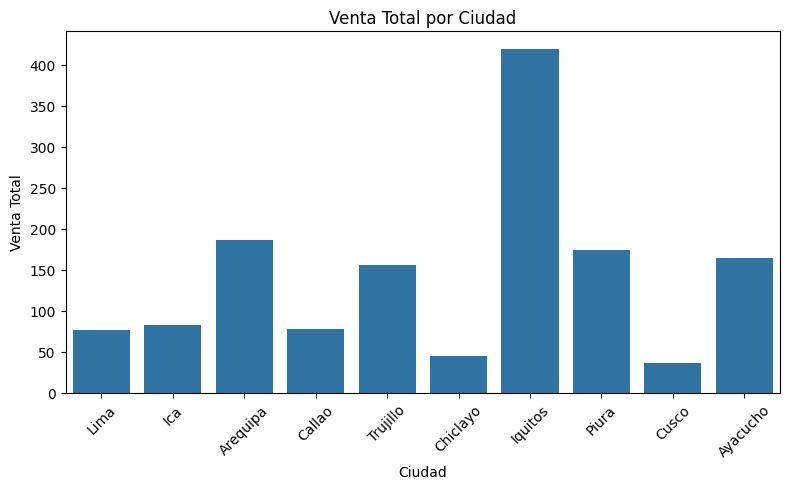

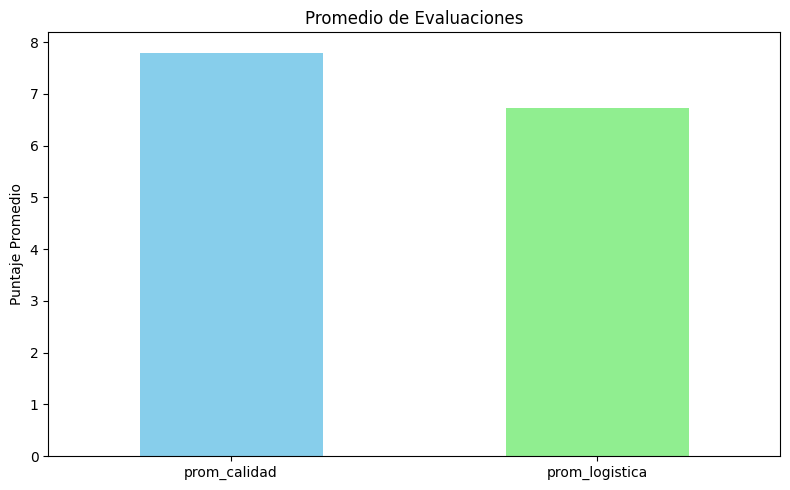

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Venta total por ciudad
plt.figure(figsize=(8, 5))
sns.barplot(x="ciudad", y="venta_total", data=df, estimator=sum)
plt.title("Venta Total por Ciudad")
plt.ylabel("Venta Total")
plt.xlabel("Ciudad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Promedios de evaluación
plt.figure(figsize=(8, 5))
df[["prom_calidad", "prom_logistica"]].mean().plot(kind="bar", color=["skyblue", "lightgreen"])
plt.title("Promedio de Evaluaciones")
plt.ylabel("Puntaje Promedio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#ETL a CSV

In [82]:
output_file = "output.csv"
df.to_csv(output_file, index=False)
print(f"Datos transformados y guardados en {output_file}")

Datos transformados y guardados en output.csv


# --- LOAD ---

In [83]:
print("Cargando datos a MongoDB...")

Cargando datos a MongoDB...


In [84]:
# Cargar datos transformados a MongoDB
output_collection = db["sales_transformed"]
output_collection.insert_many(df.to_dict("records"))
print(f"Datos cargados en la colección {output_collection.name}")
print("Proceso ETL completo.")

Datos cargados en la colección sales_transformed
Proceso ETL completo.


In [85]:
# Cerrar conexión
client.close()